## Example: Probability of a girl birth given placenta previa

In this example, we want to estimate the female birth rate.

In [7]:
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
births = torch.tensor(980.)
num_female = torch.tensor(437.)

In [3]:
births

tensor(980.)

In [4]:
def model(births, num_female):
    theta = pyro.sample("theta", dist.Uniform(0, 1))
    return pyro.sample("rate", dist.Binomial(total_count=births, probs=theta), obs=num_female)

In [5]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel,
           num_samples=20000,
           warmup_steps=10000)

In [6]:
mcmc.run(births, num_female)

Sample: 100%|██████████| 30000/30000 [02:01, 247.45it/s, step size=9.74e-01, acc. prob=0.927]


In [7]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.45      0.02      0.45      0.42      0.47   6514.93      1.00

Number of divergences: 0


The book now introduces the 'sex ratio' which is the ratio of male births to female births. We can model this using `pyro.deterministic` as below:

In [88]:
def model_2(births, num_female):
    female_rate = pyro.sample("female_rate", dist.Uniform(0, 1))
    trans_val = pyro.deterministic("trans_val", torch.log(female_rate / (1 - female_rate)))
    trans = pyro.param("trans", trans_val)
    phi_val = pyro.deterministic("phi_val", (1 - female_rate) / female_rate)
    phi = pyro.param("phi", phi_val)
    sex_ratio = pyro.sample("sex_ratio", dist.Binomial(total_count=births, probs=female_rate), obs=num_female)


In [89]:
nuts_kernel = NUTS(model_2)
mcmc = MCMC(nuts_kernel,
           num_samples=20000,
           warmup_steps=10000)

In [90]:
mcmc.run(births, num_female)

Sample: 100%|██████████| 30000/30000 [02:53, 173.30it/s, step size=8.59e-01, acc. prob=0.947]


In [91]:
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  female_rate      0.45      0.02      0.45      0.42      0.47   8405.49      1.00

Number of divergences: 0


In [92]:
posterior = Predictive(model, mcmc.get_samples()).get_samples(births, num_female)

In [93]:
posterior

{'phi': tensor([1.2427, 1.3184, 1.1339,  ..., 1.4135, 1.3519, 1.2659]),
 'sex_ratio': tensor([437., 437., 437.,  ..., 437., 437., 437.])}

## Estimating a rate from Poisson data: Asthma Death Rates

In [9]:
samples = dist.Gamma(3., 5.).sample_n(10000)

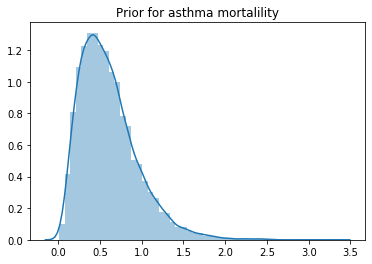

In [10]:
sns.distplot(samples.numpy())
plt.title("Prior for asthma mortalility")
plt.show();

In [11]:
def asthma_model():
    theta = pyro.sample("theta", dist.Gamma(3., 5.))
    post = pyro.sample("post", dist.Poisson(rate=theta * 2), obs=torch.tensor(3.))

In [12]:
asthma_kernel = NUTS(asthma_model)
asthma_mcmc = MCMC(asthma_kernel,
           num_samples=20000,
           warmup_steps=10000)

In [13]:
asthma_mcmc.run()

Sample: 100%|██████████| 30000/30000 [01:49, 275.13it/s, step size=7.74e-01, acc. prob=0.949]


In [ ]:
asthma_mcmc.summary()

In this updated example, we know that 30 people died of asthma related illness over 10 years. Instead up updating our prior, Gamma, distribution, we change the `obs` figure to reflect this.

This will show us how the asthma mortality rate differs.

In [11]:
def asthma_model_2():
    theta = pyro.sample("theta", dist.Gamma(3., 5.))
    post = pyro.sample("post", dist.Poisson(rate=theta * 20), obs=torch.tensor(30.))


In [12]:
asthma_kernel_2 = NUTS(asthma_model_2)
asthma_mcmc_2 = MCMC(asthma_kernel_2,
           num_samples=20000,
           warmup_steps=10000)

In [13]:
asthma_mcmc_2.run()

Sample: 100%|██████████| 30000/30000 [01:27, 341.97it/s, step size=1.13e+00, acc. prob=0.902]


In [14]:
asthma_mcmc_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      1.32      0.23      1.31      0.96      1.70   7717.06      1.00

Number of divergences: 0
